# Toy 1d Example for Review Paper

In [1]:
from pathlib import Path
from utils import *

base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')
out_dir = base_dir / 'out' / 'review_final'

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [2]:
key = jr.key(325234)

# plot settings
n_grid = 100
n_mc = int(1e5)

# exact inverse problem
noise_sd = 0.1
time_horizon = (-3, 3)
support = (0, 1)
true_param = 0.5
n_time = 8

# surrogate settings
x_design = jnp.array([0.0, 0.4, 0.9]).reshape(-1, 1) # [0.4, 0.8, 0.9]
jitter = 0.0

In [3]:
# Plotting
interval_prob = 0.95
post_ylim = (0.0, 0.16)

gp_colors = {
    "mean":     "#AA3377",
    "interval": "#EEBBDD",
    "points":   "#888888",
    "true":     "#000000"
}

approx_colors = set_plot_theme()

# sns.set_theme(style='ticks', palette='colorblind')
sns.set_context(
    "paper",
    font_scale=3.0,
    rc={"lines.linewidth": 3,
        "axes.linewidth": 1.5}
)

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


## Exact Inverse Problem

In [4]:
# Forward Model
times = jnp.linspace(time_horizon[0], time_horizon[1], n_time)
noise_var = noise_sd ** 2

def forward(u):
    u = jnp.atleast_2d(u)
    xt = jnp.exp(u * times)
    return jnp.mean(xt, axis=1)

In [5]:
# Ground truth
key, key_noise = jr.split(key)

true_observable = forward(true_param)
true_noise = noise_sd * jr.normal(key_noise)
y = true_observable + true_noise

In [6]:
# exact inverse problem 

def log_det_term(u):
    return -0.5 * jnp.log(2*jnp.pi*noise_var)

def log_lik(u):
    return log_det_term(u) - 0.5 * (y - forward(u))**2 / noise_var

class Prior1d(Prior):

    @property
    def dim(self):
        return 1

    @property
    def support(self):
        return support
     
    @property
    def par_names(self):
        return ['u']
    
    def log_density(self, u):
        u = jnp.atleast_2d(u)
        n_inputs = u.shape[0]
        a,b = self.support
        log_dens = -jnp.log(b - a)
        return jnp.tile(log_dens, n_inputs)
    
    def sample(self, key, n: int = 1):
        return jr.uniform(key, shape=(n, self.dim), 
                          minval=self.support[0],
                          maxval=self.support[1])
    
    def sample_lhc(self, key, n: int = 1):
        """Latin hypercube sample"""
        rng_key = _numpy_rng_seed_from_jax_key(key)
        rng = default_rng(seed=rng_key)
        lhc = qmc.LatinHypercube(d=self.dim, rng=rng)

        samp = lhc.random(n=n)
        a,b = self.support
        return jnp.asarray(a + samp * (b - a))
    
prior = Prior1d()
posterior = Posterior(prior, log_lik)

In [7]:
grid = Grid(low=support[0], high=support[1], 
            n_points_per_dim=n_grid, 
            dim_names=prior.par_names)

## Forward Model Surrogate

In [8]:
# construct design
forward_design = gpx.Dataset(X=x_design,
                             y=forward(x_design).reshape(-1, 1))

# fit GP surrogate
forward_gp, _ = construct_gp(forward_design, set_bounds=False, prior_mean='constant')

sd = jnp.sqrt(forward_gp.prior.kernel.variance.get_value())
sd_new = 6 * sd
forward_gp.prior.kernel.variance.set_value(sd_new ** 2)

forward_surrogate = wrap_gp(forward_gp, forward_design, jitter)

# Induced posterior surrogate
fwd_post_surr = FwdModelGaussianSurrogateGrid(gp=forward_surrogate,
                                              log_prior=posterior.prior.log_density,
                                              y=y.reshape(1,1),
                                              noise_cov_tril=jnp.array(noise_sd).reshape(1, 1),
                                              support=posterior.support)

key, key_samp = jr.split(key)
post_em_fwd = SurrogatePost1d(post_em=fwd_post_surr,
                              post_true=posterior,
                              filename_label='fwdem',
                              target_label=r'$G(u)$',
                              f_target=forward,
                              grid=grid,
                              key=key_samp,
                              n_mc=n_mc,
                              plot_surrogate_fn=plot_gp_surrogate,
                              plot_log_dens_surrogate_fn=plot_log_dens_surrogate_fwd,
                              plot_dens_surrogate_fn=plot_dens_surrogate_fwd)

In [9]:
# Forward model plots: left column of figures
# fig, ax = post_em_fwd.plot_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# fig.savefig(out_dir / f'gp_dist_{post_em_fwd.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_fwd.plot_log_dens_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# fig.savefig(out_dir / f'lpost_dist_{post_em_fwd.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_fwd.plot_dens_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# fig.savefig(out_dir / f'post_dist_{post_em_fwd.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_fwd.plot_norm_dens_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# ax.set_xlabel('u')
# fig.savefig(out_dir / f'post_norm_dist_{post_em_fwd.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_fwd.plot_post_approx(post_ylim=post_ylim, post_colors=approx_colors)
# ax.set_xlabel('u')
# fig.savefig(out_dir / f'post_approx_{post_em_fwd.filename_label}.png', bbox_inches='tight')

## Log-Density Surrogate

In [10]:
# same design inputs as forward model surrogate
ldens_design = gpx.Dataset(X=forward_design.X,
                           y=posterior.log_density(forward_design.X).reshape(-1, 1))

# fit GP surrogate
ldens_gp, _ = construct_gp(ldens_design, set_bounds=False, prior_mean='constant')

sd = jnp.sqrt(ldens_gp.prior.kernel.variance.get_value())
sd_new = 6 * sd
ldens_gp.prior.kernel.variance.set_value(sd_new ** 2)

ldens_surrogate = wrap_gp(ldens_gp, ldens_design, jitter)

# Induced posterior surrogate    
ldens_post_surr = LogDensGPSurrogateGrid(log_dens=ldens_surrogate, support=posterior.support)

key, key_samp = jr.split(key)
post_em_ldens = SurrogatePost1d(post_em=ldens_post_surr,
                              post_true=posterior,
                              filename_label='ldensem',
                              target_label=r'$\log \tilde{\pi}(u)$',
                              f_target=posterior.log_density,
                              grid=grid,
                              key=key_samp,
                              n_mc=n_mc,
                              plot_surrogate_fn=plot_gp_surrogate,
                              plot_log_dens_surrogate_fn=None, # same as plot_surrogate_fn
                              plot_dens_surrogate_fn=plot_lognorm_surrogate)

In [11]:
# GP log-density emulator plots: middle column of figure
# fig, ax = post_em_ldens.plot_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# ax.set_ylabel(None)
# fig.savefig(out_dir / f'gp_dist_{post_em_ldens.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_ldens.plot_dens_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# ax.set_ylabel(None)
# fig.savefig(out_dir / f'post_dist_{post_em_ldens.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_ldens.plot_norm_dens_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# ax.set_ylabel(None)
# ax.set_xlabel('u')
# fig.savefig(out_dir / f'post_norm_dist_{post_em_ldens.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_ldens.plot_post_approx(post_ylim=post_ylim, post_colors=approx_colors)
# ax.set_ylabel(None)
# ax.set_xlabel('u')
# fig.savefig(out_dir / f'post_approx_{post_em_ldens.filename_label}.png', bbox_inches='tight')

## Clipped Log Density Surrogate

In [12]:
def upper_bound(u):
    return log_det_term(u) + prior.log_density(u)

clip_post_surr = LogDensClippedGPSurrogateGrid(log_dens=ldens_surrogate,
                                               log_dens_upper_bound=upper_bound,
                                               support=posterior.support)

key, key_samp = jr.split(key)
post_em_clip = SurrogatePost1d(post_em=clip_post_surr,
                               post_true=posterior,
                               filename_label='clip',
                               target_label=r'$\log \tilde{\pi}(u)$',
                               f_target=posterior.log_density,
                               grid=grid,
                               key=key_samp,
                               n_mc=n_mc,
                               plot_surrogate_fn=plot_clipped_gp_surrogate,
                               plot_log_dens_surrogate_fn=None, # same as plot_surrogate_fn
                               plot_dens_surrogate_fn=plot_clipped_lnp_surrogate)

In [13]:
# Clipped GP log-density emulator plots: right column of figure
# fig, ax = post_em_clip.plot_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# ax.set_ylabel(None)
# fig.savefig(out_dir / f'gp_dist_{post_em_clip.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_clip.plot_dens_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# ax.set_ylabel(None)
# fig.savefig(out_dir / f'post_dist_{post_em_clip.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_clip.plot_norm_dens_surrogate(gp_colors=gp_colors, interval_prob=interval_prob)
# ax.set_ylabel(None)
# ax.set_xlabel('u')
# fig.savefig(out_dir / f'post_norm_dist_{post_em_clip.filename_label}.png', bbox_inches='tight')

# fig, ax = post_em_clip.plot_post_approx(post_ylim=post_ylim, post_colors=approx_colors)
# ax.set_ylabel(None)
# ax.set_xlabel('u')
# fig.savefig(out_dir / f'post_approx_{post_em_clip.filename_label}.png', bbox_inches='tight')

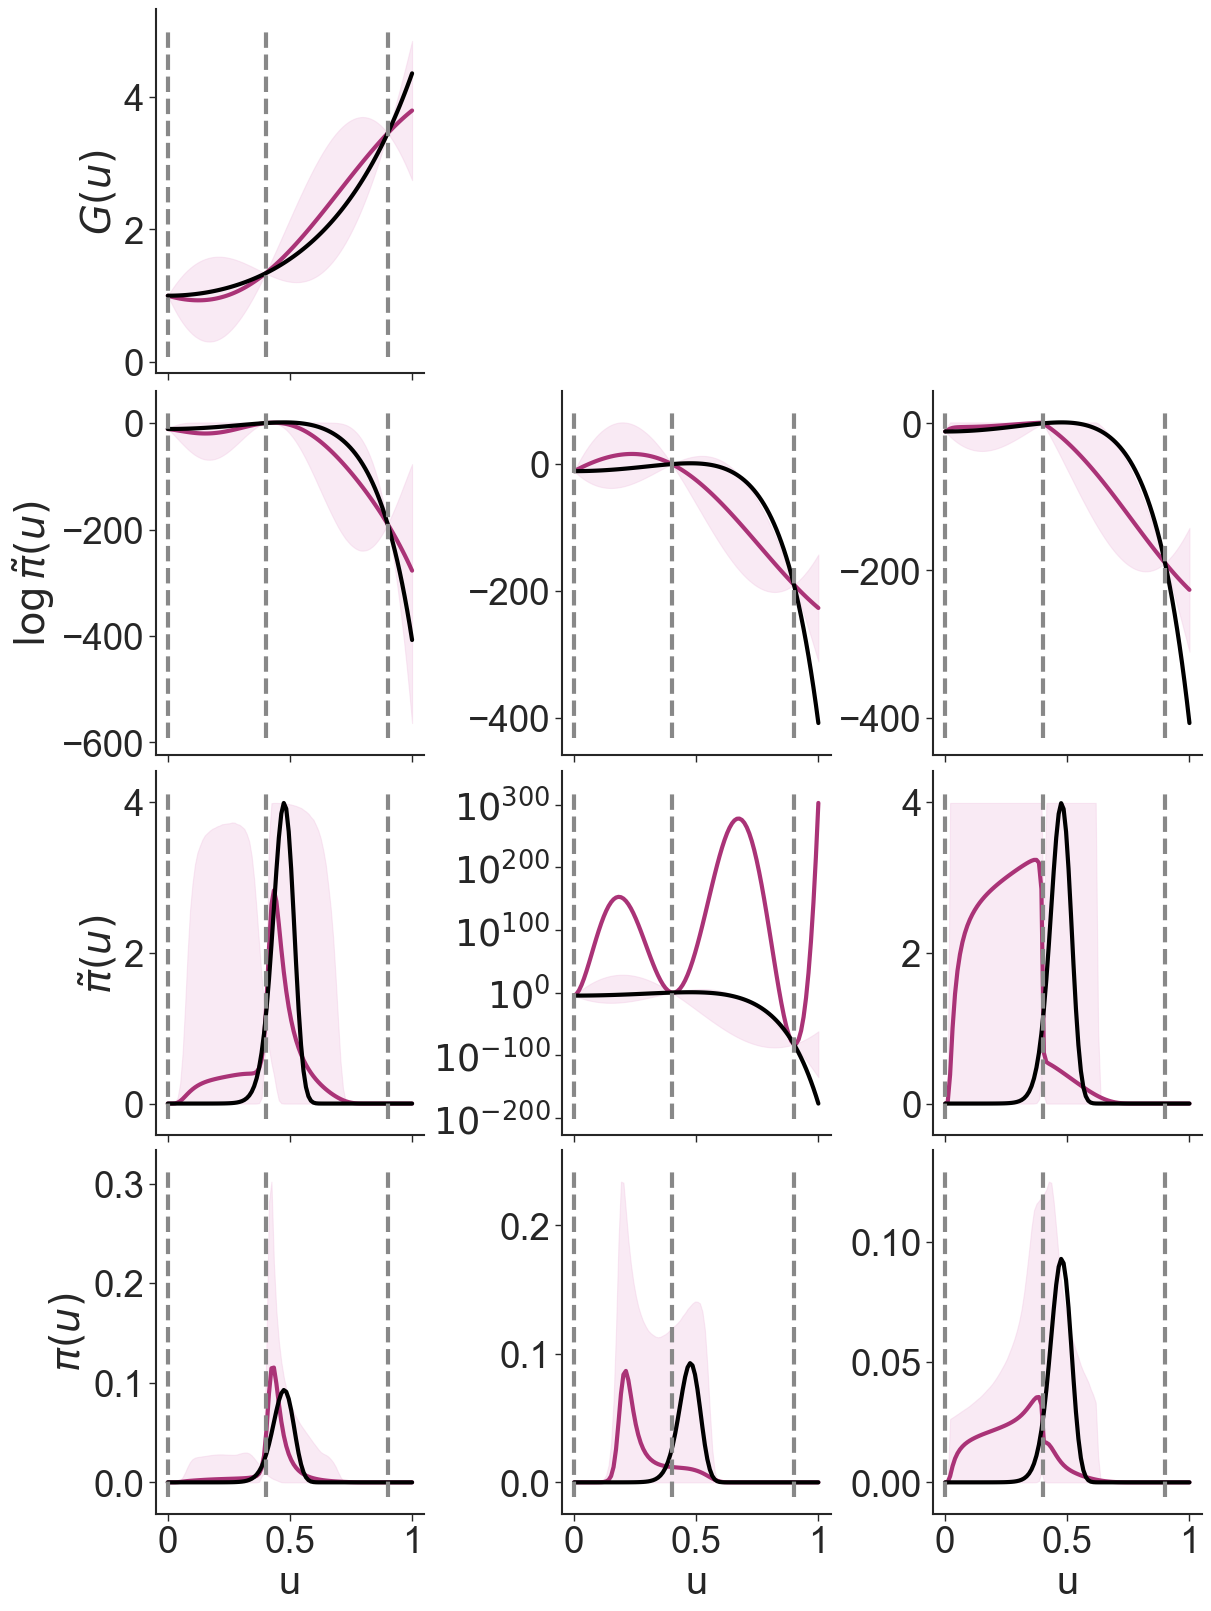

In [ ]:
# Surrogate pushforward plots

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 16), 
                         sharex='col', sharey=False, 
                         constrained_layout=True)

plot_kwargs = {'gp_colors': gp_colors, 'post_colors': approx_colors,
               'interval_prob': interval_prob, 'post_ylim': post_ylim}

plot_mapping = {
    # ROW 1
    (0, 0): post_em_fwd.plot_surrogate,
    (0, 1): None,
    (0, 2): None,
    
    # ROW 2
    (1, 0): post_em_fwd.plot_log_dens_surrogate,
    (1, 1): post_em_ldens.plot_surrogate,
    (1, 2): post_em_clip.plot_surrogate,
    
    # ROW 3
    (2, 0): post_em_fwd.plot_dens_surrogate,
    (2, 1): post_em_ldens.plot_dens_surrogate,
    (2, 2): post_em_clip.plot_dens_surrogate,
    
    # ROW 4
    (3, 0): post_em_fwd.plot_norm_dens_surrogate,
    (3, 1): post_em_ldens.plot_norm_dens_surrogate,
    (3, 2): post_em_clip.plot_norm_dens_surrogate,
}

for row in range(4):
    for col in range(3):
        ax = axes[row, col]
        fn = plot_mapping[(row,col)]

        if fn is None:
            ax.axis('off')
            continue

        fn(ax=ax, **plot_kwargs)

        ax.set_xticks([0, 0.5, 1])
        ax.set_xticklabels(['0', '0.5', '1'])

        if row == 3:
            ax.set_xlabel('u')
        if col > 0:
            ax.set_ylabel('')


plt.savefig(out_dir / 'surrogate_pushforward_grid.pdf', format='pdf', bbox_inches='tight')
plt.show()